In [22]:
import os
import cv2
import pandas as pd
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp

In [2]:
# Paths to dataset
CUB_DIR = "/kaggle/input/cub2002011/CUB_200_2011"
IMAGES_DIR = os.path.join(CUB_DIR, "images")
LABELS_DIR = "labels"
SEGMENTATION_DIR = "/kaggle/input/cub2002011/segmentations"
CLASS_FILE = os.path.join(CUB_DIR, "image_class_labels.txt")
IMAGES_FILE = os.path.join(CUB_DIR, "images.txt")

In [3]:
# Define top 20 classes
TOP_CLASSES = {1, 2, 4, 10, 11, 13, 14, 21, 25, 26, 27, 29, 30, 31, 35, 36, 38, 40, 41, 42}

In [4]:
# Create a mapping from original class IDs to 0-19
class_id_mapping = {orig_id: new_id for new_id, orig_id in enumerate(sorted(TOP_CLASSES))}

In [5]:
# Load image filenames
image_id_to_name = {}
with open(IMAGES_FILE, "r") as f:
    for line in f:
        image_id, filename = line.strip().split()
        image_id_to_name[int(image_id)] = filename

In [6]:
# Load class labels and filter only top 20
image_id_to_class = {}
with open(CLASS_FILE, "r") as f:
    for line in f:
        image_id, class_id = map(int, line.strip().split())
        if class_id in TOP_CLASSES:  # Only keep relevant classes
            image_id_to_class[image_id] = class_id_mapping[class_id]  # Convert to 0-19

In [7]:
# Prepare lists for images, masks, and labels
filtered_image_paths = []
filtered_mask_paths = []
filtered_labels = []

for image_id, new_class_id in image_id_to_class.items():
    # Get image filename
    image_filename = image_id_to_name[image_id]

    # Construct full image and mask paths
    image_full_path = os.path.join(IMAGES_DIR, image_filename)
    mask_full_path = os.path.join(SEGMENTATION_DIR, image_filename.replace(".jpg", ".png"))

    # Check if the mask exists before adding
    if os.path.exists(mask_full_path):
        filtered_image_paths.append(image_full_path)
        filtered_mask_paths.append(mask_full_path)
        filtered_labels.append(new_class_id)

# Print the number of filtered images
print(f"Total selected images: {len(filtered_image_paths)}")
print(f"Total selected masks: {len(filtered_mask_paths)}")


Total selected images: 1200
Total selected masks: 1200


In [18]:
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    filtered_image_paths, filtered_mask_paths, test_size=0.2, random_state=42
)

In [19]:
# Define Image Transformations (Resize to 128x128)
transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize images
    ToTensorV2()  # Convert to PyTorch tensors
])

class CUBSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load Image
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))  # Convert to RGB
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))  # Convert to grayscale

        # Normalize mask (0-1 range)
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        # Apply Transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask

# Create Dataset Instances
train_dataset = CUBSegmentationDataset(train_image_paths, train_mask_paths, transform=transform)
val_dataset = CUBSegmentationDataset(val_image_paths, val_mask_paths, transform=transform)


In [20]:
BATCH_SIZE = 16

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [ ]:
!pip install -q segmentation-models-pytorch --no-cache-dir

In [23]:

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define U-Net Model (Pretrained Encoder: EfficientNet, ResNet, etc.)
model = smp.Unet(
    encoder_name="resnet34",   # You can change to "efficientnet-b0", "resnet50", etc.
    encoder_weights="imagenet",  # Use pretrained weights
    in_channels=3,  # RGB images
    classes=1,  # Binary segmentation (foreground/background)
)

# Move Model to GPU
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 297MB/s]


In [25]:
# Define loss functions separately
dice_loss = smp.losses.DiceLoss(mode="binary", from_logits=True)  # Dice Loss (for segmentation)
bce_loss = nn.BCEWithLogitsLoss()  # BCE Loss (for classification)

# Custom loss function combining Dice and BCE Loss
def combined_loss(predictions, targets):
    return dice_loss(predictions, targets) + bce_loss(predictions, targets)


In [31]:
# Adam optimizer with learning rate 1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [27]:
from torchmetrics.classification import BinaryJaccardIndex

# Define IoU metric
iou_metric = BinaryJaccardIndex().to(device)

In [33]:
def train_one_epoch(model, train_loader, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0.0
    
    for images, masks in train_loader:
        masks = masks.permute(0, 3, 1, 2)
        images, masks = images.to(device), masks.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Reset gradients
        
        outputs = model(images)  # Forward pass
        loss = combined_loss(outputs, masks)  # Compute loss
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        total_loss += loss.item()
    
    return total_loss / len(train_loader)  # Return average loss

In [37]:
def validate_one_epoch(model, val_loader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_iou = 0.0
    
    with torch.no_grad():  # No gradient computation
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)  
            masks = masks.permute(0, 3, 1, 2)
            masks = (masks > 0.5).float()  
            outputs = model(images)  # Forward pass
            loss = combined_loss(outputs, masks)  # Compute loss
            
            # Compute IoU score
            predicted_masks = torch.sigmoid(outputs) > 0.5  # Convert logits to binary masks
            iou_score = iou_metric(predicted_masks, masks).item()
            
            total_loss += loss.item()
            total_iou += iou_score
    
    avg_loss = total_loss / len(val_loader)
    avg_iou = total_iou / len(val_loader)
    
    return avg_loss, avg_iou  # Return validation loss and IoU score

In [38]:
EPOCHS = 20  # Number of epochs

best_iou = 0  # Track the best IoU score
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_iou = validate_one_epoch(model, val_loader, device)
    
    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")

    # Save best model based on validation IoU
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), "best_unet_model.pth")
        print("✔ Best model saved!")

Epoch 1/20: Train Loss: 0.3840 | Val Loss: 0.3731 | Val IoU: 0.7748
✔ Best model saved!
Epoch 2/20: Train Loss: 0.3089 | Val Loss: 0.3210 | Val IoU: 0.7892
✔ Best model saved!
Epoch 3/20: Train Loss: 0.2626 | Val Loss: 0.2876 | Val IoU: 0.8030
✔ Best model saved!
Epoch 4/20: Train Loss: 0.2310 | Val Loss: 0.2602 | Val IoU: 0.8122
✔ Best model saved!
Epoch 5/20: Train Loss: 0.2029 | Val Loss: 0.2470 | Val IoU: 0.8146
✔ Best model saved!
Epoch 6/20: Train Loss: 0.1868 | Val Loss: 0.2250 | Val IoU: 0.8262
✔ Best model saved!
Epoch 7/20: Train Loss: 0.1726 | Val Loss: 0.2179 | Val IoU: 0.8249
Epoch 8/20: Train Loss: 0.1605 | Val Loss: 0.2076 | Val IoU: 0.8312
✔ Best model saved!
Epoch 9/20: Train Loss: 0.1546 | Val Loss: 0.1994 | Val IoU: 0.8333
✔ Best model saved!
Epoch 11/20: Train Loss: 0.1393 | Val Loss: 0.1952 | Val IoU: 0.8328
Epoch 12/20: Train Loss: 0.1325 | Val Loss: 0.1930 | Val IoU: 0.8317
Epoch 13/20: Train Loss: 0.1301 | Val Loss: 0.1864 | Val IoU: 0.8367
✔ Best model saved!
E

In [ ]:
# Recreate the model architecture
model = smp.Unet(
    encoder_name="resnet34",  # Use the same encoder as in training
    encoder_weights=None,  # Do NOT use pretrained weights here
    in_channels=3,
    classes=1
)

# Load trained weights
model.load_state_dict(torch.load("best_unet_model.pth", map_location=torch.device("cpu")))
model.eval()  # Set to evaluation mode


In [41]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to match training input
        transforms.ToTensor(),          # Convert to tensor
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Load a test image
image_path = "/kaggle/input/cub2002011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg"
image_tensor = preprocess_image(image_path)

# Predict
with torch.no_grad():
    output = model(image_tensor)

# Convert output to binary mask
predicted_mask = (output.squeeze(0).squeeze(0) > 0.5).numpy().astype(np.uint8)

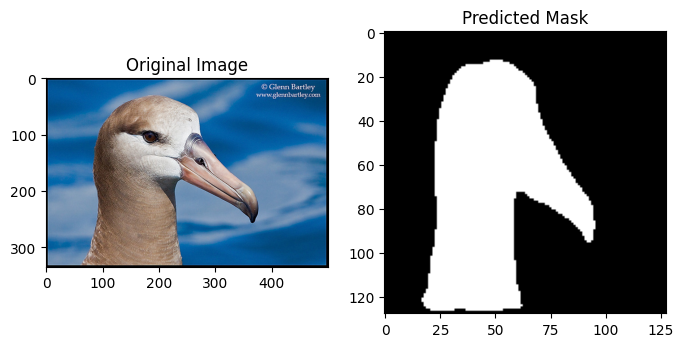

In [45]:
import matplotlib.pyplot as plt

original_image = Image.open(image_path)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")

plt.show()